# TimeGAN para Generación de Datos Sintéticos

## Implementación de Fase 2.2 para Tesis de Grado en Ingeniería en Ciencias de la Computación
______________________________________
- Escuela Politécnica Nacional

- Jeimmy Eche

______________
El presente notebook, reutiliza código para entrenar modelos de regresión y predecir la energía (Hamiltoniana) a partir de un entrenamiento centrado en datos pasivos de la mano **derecha**. Los modelos evaluados fueron:

- ✅ Random Forest
- ✅ Red Neuronal Artificial (ANN)
- ✅ Regresión Lineal

Como extensión, se propuso entrenar y comparar dos nuevos modelos más robustos:

- ✅ Gradient Boosting
- ✅ HistGradientBoosting

Ambos modelos fueron entrenados sobre los mismos datos reales pasivos preprocesados, y mostraron **mejor desempeño** en MSE y R² en comparación con los métodos anteriores.
___________

In [1]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#import plotly.express as px
import numpy as np
import random as rnd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import classification_report,confusion_matrix
import glob

# Datos Salma

## Unir Archivos entrenar modelo


In [ ]:
# Lista de nombres de archivos y etiquetas
file_list = ['pasivo_izq_01.txt','pasivo_izq_02.txt','pasivo_izq_03.txt','pasivo_izq_04.txt','pasivo_izq_05.txt']
exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']

# Crear una lista para almacenar los DataFrames
dataframes = []

# Leer cada archivo y agregar la etiqueta correspondiente
for file, label in zip(file_list, exercise_labels):
    dfDer = pd.read_csv(file, sep='\t')
    # Agregar una columna "Etiqueta" con el nombre del ejercicio
    dfDer['Etiqueta'] = label
    dataframes.append(dfDer)

# Concatenar los DataFrames en uno solo
dfDer = pd.concat(dataframes, ignore_index=True)

# Guardar el DataFrame unificado en un archivo CSV
dfDer.to_csv('archivo_unificadoIzqPasivo.csv', index=False)

In [2]:
dfDer = pd.read_csv(rf'C:\TIC_JE\Pasivos\realData\archivo_unificadoDerPasivo.csv')

##Eliminacion de variables

In [3]:
dfDer = dfDer.drop(columns=['tau0_01'])
dfDer = dfDer.drop(columns=['tau1_01'])
dfDer = dfDer.drop(columns=['tau2_01'])

dfDer = dfDer.drop(columns=['pydr_01'])
dfDer = dfDer.drop(columns=['pxdr_01'])
dfDer = dfDer.drop(columns=['pzdr_01'])

dfDer = dfDer.drop(columns=['veld1_01'])
dfDer = dfDer.drop(columns=['veld2_01'])
dfDer = dfDer.drop(columns=['veld3_01'])

dfDer = dfDer.drop(columns=['q1r_01'])


In [4]:
dfDer['H'] = pd.to_numeric(dfDer['H'], errors='coerce')


In [5]:
dfDer.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tt_01,11163.0,11.171578,6.469043,0.000000,5.580000,1.116000e+01,16.740000,23.600000
pxr_01,11163.0,0.001822,0.013749,-0.019185,-0.012293,3.862741e-03,0.016098,0.023039
pyr_01,11163.0,-0.156115,0.001939,-0.164576,-0.157091,-1.557767e-01,-0.154812,-0.152794
pzr_01,11163.0,0.004198,0.012401,-0.017977,-0.007603,6.127808e-03,0.015727,0.030098
vel1_01,11163.0,-0.000069,0.007821,-0.094521,-0.000004,8.419589e-09,0.000136,0.066406
vel2_01,11163.0,-0.000067,0.006132,-0.152574,-0.000026,0.000000e+00,0.000004,0.192838
vel3_01,11163.0,0.000257,0.010168,-0.400711,-0.000035,1.198648e-11,0.000247,0.228018
H,8882.0,-0.000470,0.002434,-0.005894,-0.002060,-4.309907e-04,0.001165,0.135018


In [6]:
dfDer.isnull().sum()

tt_01          0
pxr_01         0
pyr_01         0
pzr_01         0
vel1_01        0
vel2_01        0
vel3_01        0
H           2281
Etiqueta       0
dtype: int64

In [7]:
#dfDer = dfDer.dropna(subset=['H'])
dfDer.dropna(subset=['H'], inplace=True)


In [8]:
numeric_cols = (
    dfDer
    .select_dtypes(include=[np.number])
    .columns
    .drop('tt_01')   # excluimos tt_01 para no tratarlo como “feature”
)

## Atipicos

In [10]:
def remove_outliers_by_group(df, cols, thresh=1.5):
    def f(gr):
        Q1 = gr[cols].quantile(0.25)
        Q3 = gr[cols].quantile(0.75)
        IQR = Q3 - Q1
        mask = ~(
            (gr[cols] < (Q1 - thresh * IQR)) |
            (gr[cols] > (Q3 + thresh * IQR))
        ).any(axis=1)
        return gr.loc[mask]
    return df.groupby('Etiqueta', group_keys=False).apply(f)


In [11]:
dfCleanDer = remove_outliers_by_group(dfDer, numeric_cols)

C:\Users\Jeimm\AppData\Local\Temp\ipykernel_13972\3603781653.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Etiqueta', group_keys=False).apply(f)


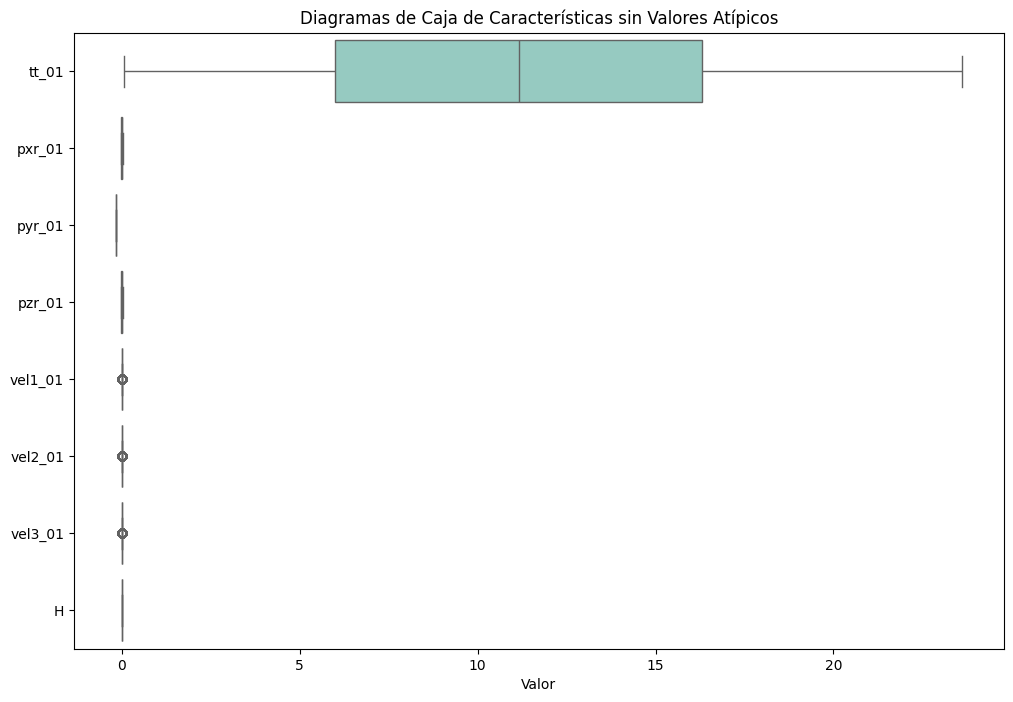

In [12]:
# Crear diagramas de caja para las características filtradas
plt.figure(figsize=(12, 8))
sns.boxplot(data=dfCleanDer , orient='h', palette='Set3')
plt.title('Diagramas de Caja de Características sin Valores Atípicos')
plt.xlabel('Valor')
plt.show()

## Grafica de posicion

In [ ]:
fig = px.scatter_3d(dfDer, x='pxr_01', y='pyr_01', z='pzr_01', color_continuous_scale='viridis')
fig.update_layout(scene=dict(xaxis_title='pxr_01', yaxis_title='pyr_01', zaxis_title='pzr_01'))
fig.show()


## Grafica de Energia

In [13]:
dfDer = dfDer[dfDer['tt_01'] < 20]

In [14]:
# Obtener todas las etiquetas únicas de ejercicios
exercise_labels = dfDer['Etiqueta'].unique()

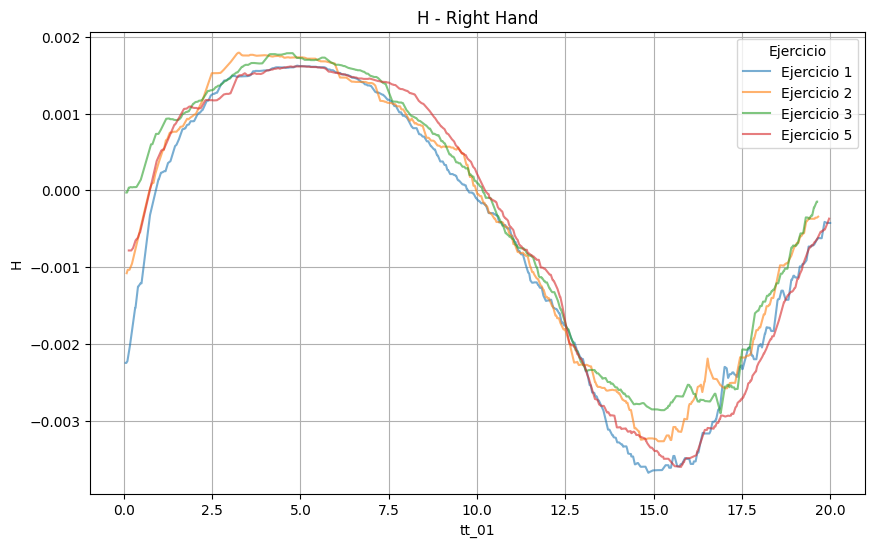

In [15]:
dfCleanDer = dfCleanDer[dfCleanDer['tt_01'] <= 20]

# 6) Plotea H vs tt_01 para cada ejercicio
plt.figure(figsize=(10,6))
for lbl in dfCleanDer['Etiqueta'].unique():
    seg = dfCleanDer[dfCleanDer['Etiqueta']==lbl]
    plt.plot(seg['tt_01'], seg['H'], label=lbl, alpha=0.6)

plt.title('H - Right Hand')
plt.xlabel('tt_01')
plt.ylabel('H')
plt.legend(title='Ejercicio')
plt.grid(True)
plt.show()

In [16]:
dfCleanDer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3304 entries, 5 to 10799
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tt_01     3304 non-null   float64
 1   pxr_01    3304 non-null   float64
 2   pyr_01    3304 non-null   float64
 3   pzr_01    3304 non-null   float64
 4   vel1_01   3304 non-null   float64
 5   vel2_01   3304 non-null   float64
 6   vel3_01   3304 non-null   float64
 7   H         3304 non-null   float64
 8   Etiqueta  3304 non-null   object 
dtypes: float64(8), object(1)
memory usage: 258.1+ KB


## Entrenamiento Modelos

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import math


In [18]:
dfCleanDer

,tt_01,pxr_01,pyr_01,pzr_01,vel1_01,vel2_01,vel3_01,H,Etiqueta
5,0.05,0.019254,-0.156794,0.016315,1.719204e-05,7.165621e-13,1.168232e-06,-0.002248,Ejercicio 1
6,0.06,0.019254,-0.156794,0.016315,3.719289e-07,0.000000e+00,2.527335e-08,-0.002248,Ejercicio 1
7,0.07,0.019254,-0.156794,0.016315,8.046228e-09,0.000000e+00,5.467582e-10,-0.002248,Ejercicio 1
10,0.10,0.019261,-0.156774,0.016220,1.974150e-07,6.164914e-07,-2.905207e-06,-0.002226,Ejercicio 1
16,0.16,0.019312,-0.156613,0.015465,7.146607e-07,2.267684e-06,-1.051712e-05,-0.002051,Ejercicio 1
...,...,...,...,...,...,...,...,...,...
10785,19.83,0.019165,-0.154028,0.006952,3.647455e-06,1.715484e-05,-6.737806e-05,-0.000510,Ejercicio 5
10786,19.84,0.019165,-0.154028,0.006952,7.890824e-08,3.711241e-07,-1.457642e-06,-0.000510,Ejercicio 5
10787,19.85,0.019165,-0.154028,0.006952,1.707084e-09,8.028818e-09,-3.153432e-08,-0.000510,Ejercicio 5
10795,19.93,0.019209,-0.153956,0.006283,9.704677e-07,3.821749e-06,-1.482220e-05,-0.000419,Ejercicio 5


In [19]:
dfCleanDer = dfCleanDer.drop(columns=['tt_01'])
dfCleanDer = dfCleanDer.drop(columns=['Etiqueta'])


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
import joblib
import os
from keras import backend as K

K.clear_session()
out_dir = r'C:\TIC_JE\Pasivos\modelos\derechaP'
os.makedirs(out_dir, exist_ok=True)


X = dfCleanDer.drop(columns=['H'])
y = dfCleanDer['H']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(out_dir, 'scaler_der.pkl'))
n_features = X_train_scaled.shape[1]
#X_train_scaled = X_train
#X_test_scaled = X_test
# Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
joblib.dump(linear_model, os.path.join(out_dir, 'linear_model_der.pkl'))


# Configuración de SVR y búsqueda de hiperparámetros


random_forest = RandomForestRegressor(n_estimators=10, random_state=42)
random_forest.fit(X_train_scaled, y_train)
joblib.dump(random_forest, os.path.join(out_dir, 'rf_model_der.pkl'))

# ANN (Red Neuronal Artificial)
ann_model = Sequential()
ann_model.add(Dense(units=50, activation='relu', input_dim=6))
ann_model.add(Dense(units=30, activation='relu'))
ann_model.add(Dense(units=1))
ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
ann_model.summary()
ann_model.save(os.path.join(out_dir, 'ann_model_der.h5'))
# Evaluación de modelos
models = [linear_model, random_forest, ann_model]
model_names = ['Regresión Lineal', 'RandomForestRegressor', 'ANN']

for i, model in enumerate(models):
    X_test_model = X_test_scaled
    y_pred = model.predict(X_test_model)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_names[i]} - MSE: {format(mse, ".2e")}, R2: {r2:.4f}')


c:\TIC_JE\envi\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,735 (22.41 KB)

 Trainable params: 1,911 (7.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,824 (14.94 KB)

Regresión Lineal - MSE: 7.40e-08, R2: 0.9767
RandomForestRegressor - MSE: 1.46e-10, R2: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
ANN - MSE: 2.12e-08, R2: 0.9933


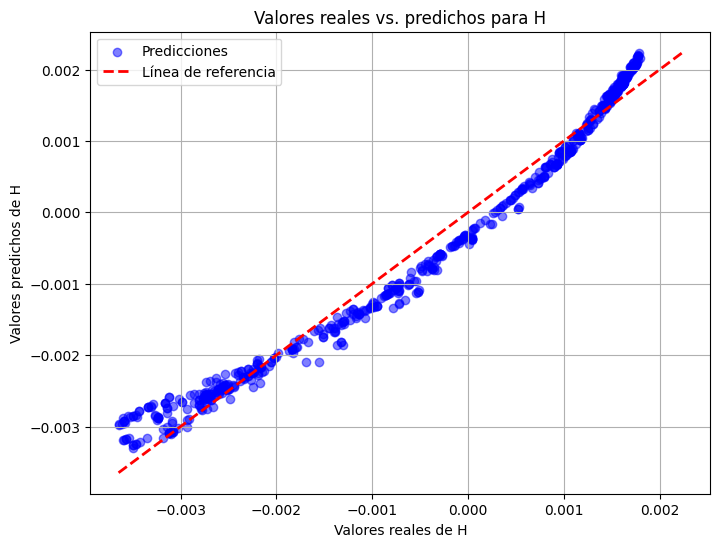

In [21]:
# Realizar predicciones de H
y_pred = linear_model.predict(X_test_scaled)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, c='b', label='Predicciones', alpha=0.5)

# Línea de identidad
lims = [
  min(y_test.min(),  y_pred.min()),
  max(y_test.max(),  y_pred.max())
]
plt.plot(lims, lims, 'r--', lw=2, label='Línea de referencia')

plt.xlabel('Valores reales de H')
plt.ylabel('Valores predichos de H')
plt.title('Valores reales vs. predichos para H')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
coeficientes_beta = linear_model.coef_
intercepto_beta = linear_model.intercept_

print("Coeficientes Beta:", coeficientes_beta)
print("Intercepto Beta:", intercepto_beta)

Coeficientes Beta: [-7.23903940e-05 -5.61472891e-05 -1.77536295e-03 -8.32005474e-06
 -1.14267219e-05 -1.47825153e-05]
Intercepto Beta: -0.00048684305479341263


In [23]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# GBR clásico
gbr = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.05,
    max_depth=4, subsample=0.8, random_state=42
)
gbr.fit(X_train_scaled, y_train)
joblib.dump(gbr, os.path.join(out_dir, 'gbr_model_der.pkl'))
y_pred_gbr = gbr.predict(X_test_scaled)
print('GBR       - MSE: {:.2e}, R2: {:.4f}'.format(
    mean_squared_error(y_test, y_pred_gbr),
    r2_score(y_test, y_pred_gbr))
)

# HistGradientBoosting (más rápido)
hgb = HistGradientBoostingRegressor(
    max_iter=200, learning_rate=0.05,
    max_depth=4, random_state=42
)
hgb.fit(X_train_scaled, y_train)
joblib.dump(hgb, os.path.join(out_dir, 'hgb_model_der.pkl'))
y_pred_hgb = hgb.predict(X_test_scaled)
print('HistGBR   - MSE: {:.2e}, R2: {:.4f}'.format(
    mean_squared_error(y_test, y_pred_hgb),
    r2_score(y_test, y_pred_hgb))
)


GBR       - MSE: 1.33e-10, R2: 1.0000
HistGBR   - MSE: 2.22e-10, R2: 0.9999


In [24]:
arboles = random_forest.estimators_

print("Coeficientes Beta:", arboles)


Coeficientes Beta: [DecisionTreeRegressor(max_features=1.0, random_state=1608637542), DecisionTreeRegressor(max_features=1.0, random_state=1273642419), DecisionTreeRegressor(max_features=1.0, random_state=1935803228), DecisionTreeRegressor(max_features=1.0, random_state=787846414), DecisionTreeRegressor(max_features=1.0, random_state=996406378), DecisionTreeRegressor(max_features=1.0, random_state=1201263687), DecisionTreeRegressor(max_features=1.0, random_state=423734972), DecisionTreeRegressor(max_features=1.0, random_state=415968276), DecisionTreeRegressor(max_features=1.0, random_state=670094950), DecisionTreeRegressor(max_features=1.0, random_state=1914837113)]


In [25]:
dfCleanDer

,pxr_01,pyr_01,pzr_01,vel1_01,vel2_01,vel3_01,H
5,0.019254,-0.156794,0.016315,1.719204e-05,7.165621e-13,1.168232e-06,-0.002248
6,0.019254,-0.156794,0.016315,3.719289e-07,0.000000e+00,2.527335e-08,-0.002248
7,0.019254,-0.156794,0.016315,8.046228e-09,0.000000e+00,5.467582e-10,-0.002248
10,0.019261,-0.156774,0.016220,1.974150e-07,6.164914e-07,-2.905207e-06,-0.002226
16,0.019312,-0.156613,0.015465,7.146607e-07,2.267684e-06,-1.051712e-05,-0.002051
...,...,...,...,...,...,...,...
10785,0.019165,-0.154028,0.006952,3.647455e-06,1.715484e-05,-6.737806e-05,-0.000510
10786,0.019165,-0.154028,0.006952,7.890824e-08,3.711241e-07,-1.457642e-06,-0.000510
10787,0.019165,-0.154028,0.006952,1.707084e-09,8.028818e-09,-3.153432e-08,-0.000510
10795,0.019209,-0.153956,0.006283,9.704677e-07,3.821749e-06,-1.482220e-05,-0.000419


In [27]:
import os
import pandas as pd
import numpy as np
from joblib import load

# Directorio donde se guardarán los CSV de predicción con RandomForest
DATOS_PRED_DIR = r"C:\TIC_JE\Pasivos\datosPredDer\RF"
os.makedirs(DATOS_PRED_DIR, exist_ok=True)

def PredRF(archivonombre, archivoSave, nombreGrafica):
    """
    Lee un .txt de datos de Salma, predice H con RandomForest usando
    el StandardScaler guardado, reconstruye la serie temporal y guarda
    el resultado en CSV dentro de datosPred.
    """
    # 1) Carga el scaler de inputs que se usó en el entrenamiento
    scaler_inputs = load(r"C:\TIC_JE\Pasivos\modelos\derechaP\scaler_der.pkl")

    # 2) Define nombres de columnas y lee el archivo .txt
    column_names = [
        'tr_01','pxr_01','pyr_01','pzr_01',
        'pxdr_01','pydr_01','pzdr_01',
        'q1r_01','tau0_01','tau1_01','tau2_01',
        'vel1_01','vel2_01','vel3_01',
        'veld1_01','veld2_01','veld3_01'
    ]
    df = pd.read_csv(archivonombre, sep='\t', header=None, names=column_names)

    # 3) Convierte de milímetros (o unidades originales) a metros
    for col in ['pxr_01','pyr_01','pzr_01','vel1_01','vel2_01','vel3_01']:
        df[col] *= 0.001

    # 4) Extrae solo las 6 features que el modelo espera
    X_pred = df[['pxr_01','pyr_01','pzr_01','vel1_01','vel2_01','vel3_01']]

    # 5) Normaliza con el mismo scaler de entrenamiento
    X_scaled = scaler_inputs.transform(X_pred)

    # 6) Predicción de H
    df['Hpred0'] = random_forest.predict(X_scaled)

    # 7) (Opcional) Cálculo de error RMS para debug
    rms = np.sqrt(np.mean(df['Hpred0']**2))
    print(f"Error RMS {archivonombre}: {rms:.2e}")

    # 8) Caso especial: si es el archivo “a1_salama_der_02.txt”, recorta filas
    if archivonombre.endswith("a1_salama_der_02.txt"):
        df = df.iloc[600:].reset_index(drop=True)

    # 9) Reconstruye la columna de tiempo desde 0 con Δt = 0.001
    df['tr_01'] = np.arange(len(df)) * 0.001

    # 10) Guarda el CSV en la carpeta datosPred y devuelve el DataFrame
    save_path = os.path.join(DATOS_PRED_DIR, os.path.basename(archivoSave))
    df.to_csv(save_path, index=False)
    print(f"→ Guardado Predicción RF en: {save_path}")

    return df


In [28]:
def unifiarArchivos(listnameFile, guardarUnificadoName):
  file_list = listnameFile
  exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']

  # Crear una lista para almacenar los DataFrames
  dataframes = []
  dfDer = []
  # Leer cada archivo y agregar la etiqueta correspondiente
  for file, label in zip(file_list, exercise_labels):
      dfDer = pd.read_csv(file, sep=',')
      # Agregar una columna "Etiqueta" con el nombre del ejercicio
      dfDer['Etiqueta'] = label
      dataframes.append(dfDer)
      if (file=="a1_salama_der_Pred02.csv"):
        print(dfDer.shape)
  # Concatenar los DataFrames en uno solo
  dfDer = pd.concat(dataframes, ignore_index=True)

  # Guardar el DataFrame unificado en un archivo CSV
  dfDer.to_csv(guardarUnificadoName, index=False)
  return dfDer

In [29]:
import os
import glob

# Carpeta raíz donde tienes 'Activos 1' y 'Activos 2'
base_dir = r'C:\TIC_JE\Pasivos\realData\datosSalma'

# Carpeta donde se guardan los unificados de RF
out_base = r'C:\TIC_JE\Pasivos\datosPredDer\unificados'
os.makedirs(out_base, exist_ok=True)

# Asegúrate también de que exista la carpeta de predicciones RF
DATOS_PRED_DIR_RF = r"C:\TIC_JE\Pasivos\datosPredDer\RF"
os.makedirs(DATOS_PRED_DIR_RF, exist_ok=True)

for activo_num in ['1', '2']:
    for lado in ['izq', 'der']:
        # Patrón para todos los txt de este activo/lado
        patron_txt = os.path.join(
            base_dir,
            f'Activos {activo_num}',
            f'a{activo_num}_salama_{lado}_*.txt'
        )
        txt_files = sorted(glob.glob(patron_txt))
        pred_csvs = []

        # 1) Procesa cada txt y genera su PredCSV con RandomForest
        for txt in txt_files:
            nombre = os.path.splitext(os.path.basename(txt))[0]
            # Sufijo _PredRF.csv para distinguir
            csv_out = f'{nombre}_PredRF.csv'
            # Llama a tu función PredRF:
            df_pred = PredRF(txt, csv_out, nombre)
            # PredRF guarda en DATOS_PRED_DIR_RF, así que armamos la ruta completa:
            full_path = os.path.join(DATOS_PRED_DIR_RF, csv_out)
            pred_csvs.append(full_path)

        # 2) Unifica todos los PredRF.csv de este activo/lado
        unif_name = os.path.join(
            out_base,
            f'Activo{activo_num}_{lado}_UnificadoRF.csv'
        )
        df_unificado = unifiarArchivos(pred_csvs, unif_name)
        print(f'→ Generado unificado RF: {unif_name}  ({df_unificado.shape})')


Error RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_01.txt: 9.67e-04
→ Guardado Predicción RF en: C:\TIC_JE\Pasivos\datosPredDer\RF\a1_salama_izq_01_PredRF.csv
Error RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_02.txt: 8.99e-04
→ Guardado Predicción RF en: C:\TIC_JE\Pasivos\datosPredDer\RF\a1_salama_izq_02_PredRF.csv
Error RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_03.txt: 1.01e-03
→ Guardado Predicción RF en: C:\TIC_JE\Pasivos\datosPredDer\RF\a1_salama_izq_03_PredRF.csv
Error RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_04.txt: 1.21e-03
→ Guardado Predicción RF en: C:\TIC_JE\Pasivos\datosPredDer\RF\a1_salama_izq_04_PredRF.csv
Error RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_05.txt: 1.06e-03
→ Guardado Predicción RF en: C:\TIC_JE\Pasivos\datosPredDer\RF\a1_salama_izq_05_PredRF.csv
→ Generado unificado RF: C:\TIC_JE\Pasivos\modelos\derechaP\Activo1_izq_UnificadoRF.csv  ((6664, 19)

In [33]:
def graficarPredHA1_A2(dfCleanDer,titulo):
  # Crear una figura
  plt.figure(figsize=(10, 6))

  # Iterar a través de cada ejercicio y crear el gráfico de línea correspondiente
  for label in exercise_labels:
      # Filtrar el DataFrame para el ejercicio actual
      exercise_dfD = dfCleanDer[dfCleanDer['Etiqueta'] == label]

      # Crear el gráfico de línea para el ejercicio
      plt.plot(exercise_dfD['tr_01'], exercise_dfD['Hpred0'], label=label, alpha=0.5)

  # Configurar título y etiquetas de ejes
  plt.title(titulo)
  plt.xlabel('tt_01')
  plt.ylabel('H')

  # Mostrar leyenda con etiquetas de ejercicio
  plt.legend()

  # Mostrar el gráfico
  plt.grid(True)
  plt.show()

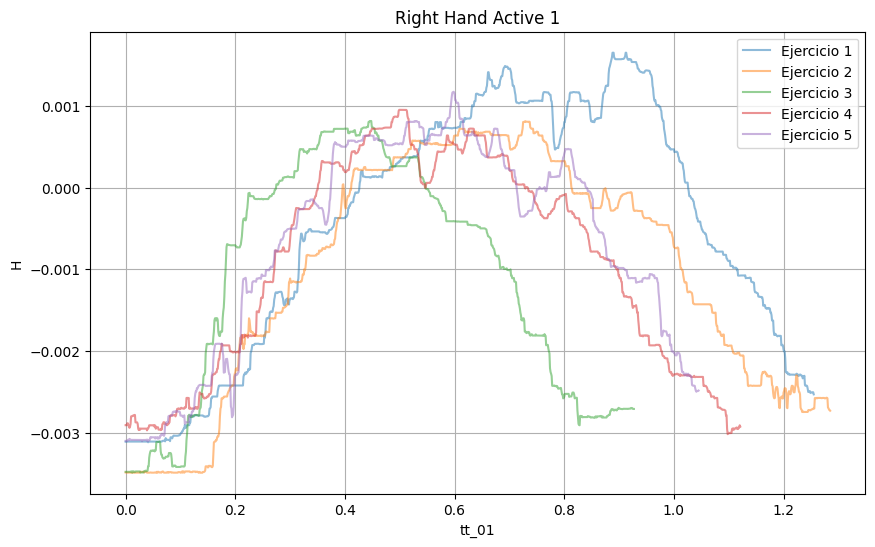

In [34]:
exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']
dfCleanDerPredA1 = pd.read_csv(r"C:\TIC_JE\Pasivos\modelos\derechaP\Activo1_der_UnificadoRF.csv")

graficarPredHA1_A2(dfCleanDerPredA1,"Right Hand Active 1")

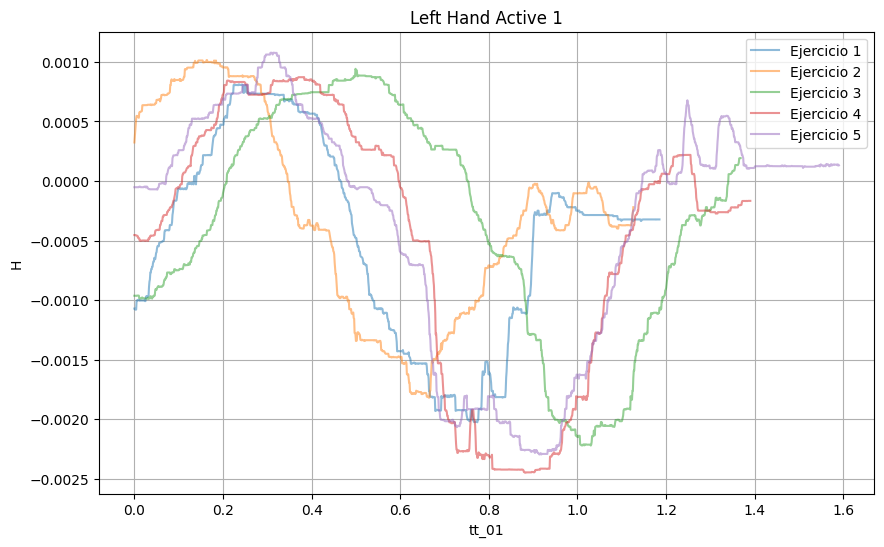

In [35]:
exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']
dfCleanDerPredA1 = pd.read_csv(r"C:\TIC_JE\Pasivos\modelos\derechaP\Activo1_izq_UnificadoRF.csv")

graficarPredHA1_A2(dfCleanDerPredA1,"Left Hand Active 1")

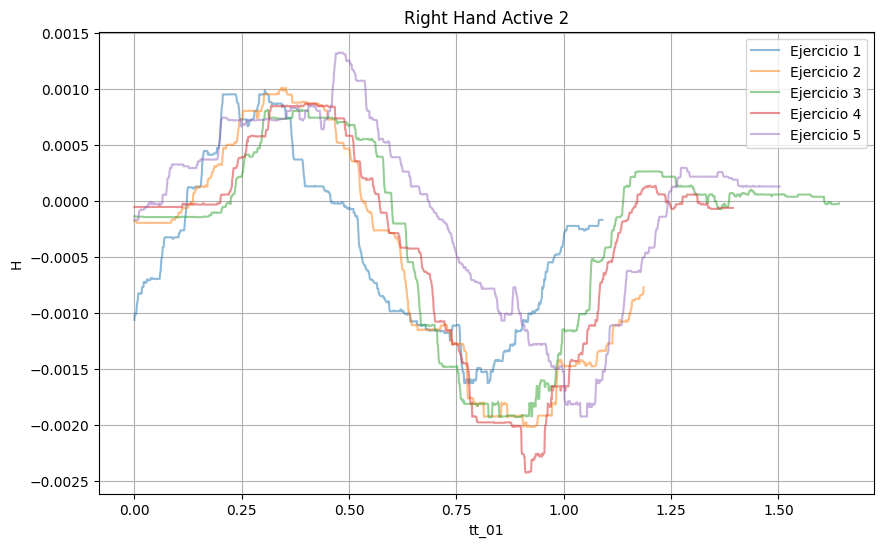

In [36]:
exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']
dfCleanDerPredA2 = pd.read_csv(r"C:\TIC_JE\Pasivos\modelos\derechaP\Activo2_der_UnificadoRF.csv")

graficarPredHA1_A2(dfCleanDerPredA2,"Right Hand Active 2")

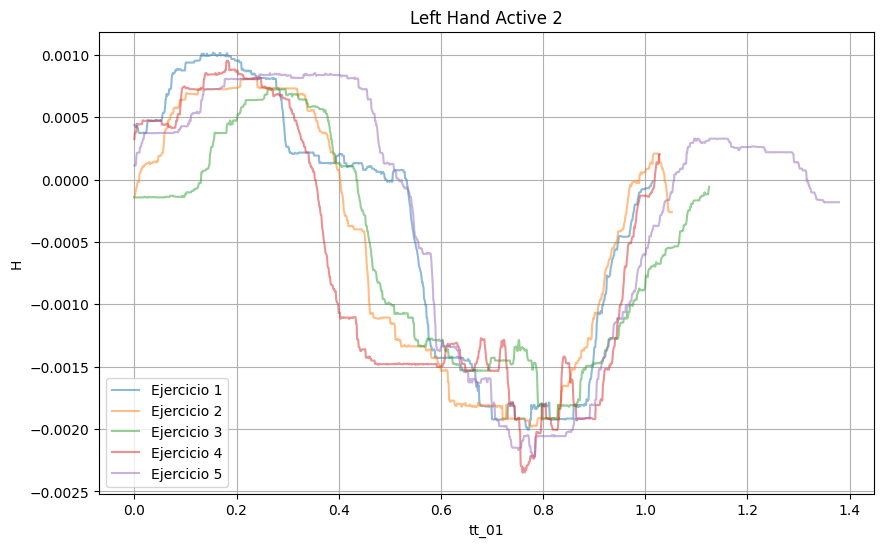

In [41]:
exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']
dfCleanDerPredA2 = pd.read_csv(r"C:\TIC_JE\Pasivos\modelos\derechaP\Activo2_izq_UnificadoRF.csv")

graficarPredHA1_A2(dfCleanDerPredA2,"Left Hand Active 2")

In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Guarda tus modelos en un diccionario con nombre legible
models = {
    'Regresión Lineal': linear_model,
    'Random Forest':    random_forest,
    'ANN':              ann_model,
    'Gradient Boosting':     gbr,
    'HistGradientBoosting':  hgb
}

# 2) Recorre cada modelo, predice y calcula métricas
results = []
for name, model in models.items():
    # Las redes Keras devuelven array 2D, aplanamos a 1D si hace falta:
    y_pred = model.predict(X_test_scaled)
    if y_pred.ndim > 1:
        y_pred = y_pred.ravel()
        
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    
    results.append({
        'Modelo': name,
        'MSE':  mse,
        'RMSE': rmse,
        'MAE':  mae,
        'R²':   r2
    })

# 3) Pásalo a DataFrame y ordénalo
df_comp = pd.DataFrame(results).sort_values('R²', ascending=False)

# 4) Míralo en pantalla
print(df_comp.to_string(index=False))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              Modelo          MSE     RMSE      MAE       R²
   Gradient Boosting 1.330555e-10 0.000012 0.000008 0.999958
       Random Forest 1.460274e-10 0.000012 0.000006 0.999954
HistGradientBoosting 2.216307e-10 0.000015 0.000011 0.999930
                 ANN 2.121990e-08 0.000146 0.000078 0.993328
    Regresión Lineal 7.402497e-08 0.000272 0.000229 0.976726


# Comparación de Modelos
## Mano derecha

| Modelo                   | MSE (×10⁻¹⁰) | RMSE (×10⁻⁵) | MAE (×10⁻⁵) | R²        |
|--------------------------|-------------:|-------------:|------------:|----------:|
| **Gradient Boosting**    |        0.133 |         0.12 |        0.08 | 0.999958 |
| **Random Forest**        |        0.146 |         0.12 |        0.06 | 0.999954 |
| **HistGradientBoosting** |        0.216 |         0.15 |        0.11 | 0.999930 |
| **Regresión Lineal**     |        0.740 |         2.72 |        2.29 | 0.976726 |
| **ANN**                  |        0.222 |         1.46 |        0.78 | 0.993328 |

## Mano izquierda

| Modelo                   | MSE (×10⁻¹⁰) | RMSE (×10⁻⁵) | MAE (×10⁻⁵) | R²        |
|--------------------------|-------------:|-------------:|------------:|----------:|
| **Gradient Boosting**    |        0.628 |         0.08 |        0.05 | 0.999976 |
| **Random Forest**        |        1.128 |         0.11 |        0.04 | 0.999956 |
| **HistGradientBoosting** |        1.713 |         0.13 |        0.08 | 0.999933 |
| **Regresión Lineal**     |      510.226 |        2.26  |       19.8  | 0.980118 |
| **ANN**                  |     3610.034 |        6.01  |       49.6  | 0.859365 |

## Conclusiones

### Mano derecha
- Todos los modelos ensemble (GB, RF, HGB) lograron **errores extremadamente bajos y R² > 0.9999**, lo que indica una **predicción muy precisa**.
- La **Red Neuronal Artificial (ANN)** tuvo peor desempeño en términos de MSE, aunque aún con R² alto.
- La **regresión lineal** tuvo errores significativamente mayores, indicando **poca capacidad para capturar la complejidad de la señal**.

### Mano izquierda
- Nuevamente, los métodos ensemble muestran **gran estabilidad y precisión**.
- La **ANN falló gravemente** en esta mano, con errores muy altos y un R² de solo **0.859**.
- La **regresión lineal** mostró una mejora respecto a ANN, pero sigue lejos de los modelos ensemble.

## Análisis Detallado

- **Gradient Boosting** fue el modelo más robusto y preciso en ambas manos, con errores mínimos y el R² más alto.
- **Random Forest** fue el segundo mejor, con diferencias mínimas frente a GB.
- Las **Redes Neuronales (ANN)** no fueron eficaces con este tipo de datos pasivos, probablemente por:
  - Poca cantidad de datos
  - Falta de optimización de hiperparámetros
  - Falta de regularización o normalización adecuada
- La **regresión lineal** sirve como línea base, pero no captura la no linealidad presente en los datos.
---

## Recomendaciones

- Evitar ANN salvo que se tenga:
  - Mayor volumen de datos
  - Ingeniería de características adicional
  - Optimización avanzada (batch size, learning rate, etc.)


# Predicción de H con el mejor modelo

In [44]:
import os
import pandas as pd
import numpy as np
from joblib import load

# Directorio donde se guardarán los CSV de predicción con el mejor modelo (Gradient Boosting)
DATOS_PRED_DIR_GB = r"C:\TIC_JE\Pasivos\datosPredDer\GB"
os.makedirs(DATOS_PRED_DIR_GB, exist_ok=True)

# Carga global del scaler y del modelo de Gradient Boosting
_SCALER_PATH_GB = r"C:\TIC_JE\Pasivos\modelos\derechaP\scaler_der.pkl"
_MODEL_PATH_GB  = r"C:\TIC_JE\Pasivos\modelos\derechaP\gbr_model_der.pkl"
scaler_inputs_gb = load(_SCALER_PATH_GB)
gbr_model        = load(_MODEL_PATH_GB)

def PredGB(archivonombre: str, archivoSave: str, nombreGrafica: str) -> pd.DataFrame:
    """
    Lee un .txt de datos de Salma, predice H con el modelo GradientBoostingRegressor
    usando el mismo StandardScaler de inputs, reconstruye la serie temporal y guarda
    el CSV de salida en datosPred\GB.
    """
    # 1) Define nombres de columnas y lee el archivo .txt
    cols = [
        'tr_01','pxr_01','pyr_01','pzr_01',
        'pxdr_01','pydr_01','pzdr_01',
        'q1r_01','tau0_01','tau1_01','tau2_01',
        'vel1_01','vel2_01','vel3_01',
        'veld1_01','veld2_01','veld3_01'
    ]
    df = pd.read_csv(archivonombre, sep='\t', header=None, names=cols)

    # 2) Conversión de unidades a metros
    for c in ['pxr_01','pyr_01','pzr_01','vel1_01','vel2_01','vel3_01']:
        df[c] *= 0.001

    # 3) Selección de features
    X = df[['pxr_01','pyr_01','pzr_01','vel1_01','vel2_01','vel3_01']]

    # 4) Escalado
    X_scaled = scaler_inputs_gb.transform(X)

    # 5) Predicción con Gradient Boosting
    df['Hpred0'] = gbr_model.predict(X_scaled)

    # 6) Debug: RMS
    rms = np.sqrt(np.mean(df['Hpred0']**2))
    print(f"[GB] RMS {archivonombre}: {rms:.2e}")

    # 7) Caso especial de recorte
    if archivonombre.endswith("a1_salama_der_02.txt"):
        df = df.iloc[600:].reset_index(drop=True)

    # 8) Reconstrucción de la serie temporal
    df['tr_01'] = np.arange(len(df)) * 0.001

    # 9) Guardado del CSV en datosPred\GB
    save_path = os.path.join(DATOS_PRED_DIR_GB, os.path.basename(archivoSave))
    df.to_csv(save_path, index=False)
    print(f"→ Guardado Predicción GB en: {save_path}")

    return df


<>:17: SyntaxWarning: invalid escape sequence '\G'
<>:17: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_13972\3807834932.py:17: SyntaxWarning: invalid escape sequence '\G'
  """


In [45]:
import os
import glob

# Carpeta raíz donde tienes 'Activos 1' y 'Activos 2'
base_dir = r'C:\TIC_JE\Pasivos\realData\datosSalma'

# Carpeta donde se guardan los unificados de GB (puedes usar la misma que antes o crear otra)
out_base = r'C:\TIC_JE\Pasivos\datosPredDer\unificados'
os.makedirs(out_base, exist_ok=True)

for activo_num in ['1','2']:
    for lado in ['izq','der']:
        # Patrón para todos los txt de este activo/lado
        patron_txt = os.path.join(
            base_dir,
            f'Activos {activo_num}',
            f'a{activo_num}_salama_{lado}_*.txt'
        )
        txt_files = sorted(glob.glob(patron_txt))
        pred_csvs = []

        # 1) Procesa cada txt y genera su PredCSV con Gradient Boosting
        for txt in txt_files:
            nombre = os.path.splitext(os.path.basename(txt))[0]
            # Le ponemos sufijo _PredGB.csv
            csv_out = f'{nombre}_PredGB.csv'
            # Llamada a tu función PredGB:
            df_pred = PredGB(txt, csv_out, nombre)
            # PredGB guarda en DATOS_PRED_DIR_GB usando solo el basename
            # Así que aquí recogemos la ruta completa:
            full_path = os.path.join(PredGB.__globals__['DATOS_PRED_DIR_GB'], csv_out)
            pred_csvs.append(full_path)

        # 2) Unifica todos los PredGB.csv de este activo/lado
        unif_name = os.path.join(
            out_base,
            f'Activo{activo_num}_{lado}_UnificadoGB.csv'
        )
        df_unificado = unifiarArchivos(pred_csvs, unif_name)
        print(f'→ Generado unificado GB: {unif_name}  ({df_unificado.shape})')


[GB] RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_01.txt: 9.48e-04
→ Guardado Predicción GB en: C:\TIC_JE\Pasivos\datosPredDer\GB\a1_salama_izq_01_PredGB.csv
[GB] RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_02.txt: 8.81e-04
→ Guardado Predicción GB en: C:\TIC_JE\Pasivos\datosPredDer\GB\a1_salama_izq_02_PredGB.csv
[GB] RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_03.txt: 9.98e-04
→ Guardado Predicción GB en: C:\TIC_JE\Pasivos\datosPredDer\GB\a1_salama_izq_03_PredGB.csv
[GB] RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_04.txt: 1.19e-03
→ Guardado Predicción GB en: C:\TIC_JE\Pasivos\datosPredDer\GB\a1_salama_izq_04_PredGB.csv
[GB] RMS C:\TIC_JE\Pasivos\realData\datosSalma\Activos 1\a1_salama_izq_05.txt: 1.04e-03
→ Guardado Predicción GB en: C:\TIC_JE\Pasivos\datosPredDer\GB\a1_salama_izq_05_PredGB.csv
→ Generado unificado GB: C:\TIC_JE\Pasivos\datosPredDer\unificados\Activo1_izq_UnificadoGB.csv  ((6664, 1

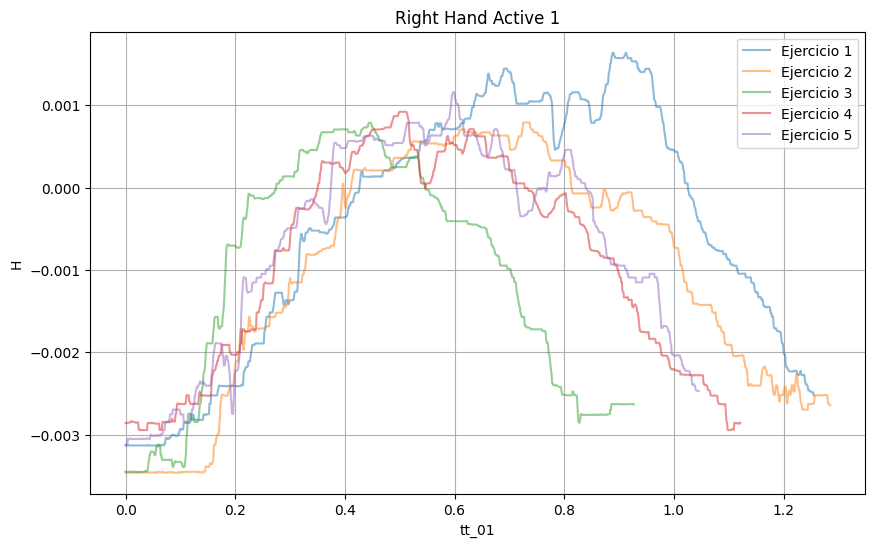

In [47]:
exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']
dfCleanDerPredA1 = pd.read_csv(r"C:\TIC_JE\Pasivos\datosPredDer\unificados\Activo1_der_UnificadoGB.csv")

graficarPredHA1_A2(dfCleanDerPredA1,"Right Hand Active 1")